# 🚀 DHARTI S2DR3 Super-Resolution Pipeline

**⚡ ONE-CLICK AUTOMATED EXECUTION ⚡**

This notebook automatically runs the complete AI super-resolution pipeline without manual configuration!

## What it does:

1. **Extracts job parameters** from URL (zero manual input needed!)
2. **Downloads S2DR3 model** from Hugging Face
3. **Runs 10m → 1m super-resolution** using deep learning
4. **Clips to your farm boundary** for precise results
5. **Uploads results back to DHARTI** automatically

## How to use:

1. Click **"Runtime" → "Run all"** (or press `Ctrl+F9` / `Cmd+F9`)
2. Wait 3-5 minutes for processing
3. Results appear automatically in DHARTI!

> **No configuration needed!** All parameters are extracted from the URL when opened from DHARTI.

---

## Processing Time

- **With GPU (T4)**: ~3 minutes ⚡
- **CPU only**: ~8-10 minutes 🐢

💡 **Tip**: Go to "Runtime" → "Change runtime type" → Select "T4 GPU" for faster processing!

---


In [3]:
# ============================================================================
# 1. AUTO-EXTRACT PARAMETERS FROM URL (ZERO-CLICK CONFIGURATION)
# ============================================================================
import re
import time
import os
import sys

print("🔍 Auto-detecting DHARTI configuration...")

# Check if API base was passed via command line or environment
api_base = None
job_id = None

# Method 1: Check command line arguments (if notebook was launched with params)
if len(sys.argv) > 1:
    for arg in sys.argv[1:]:
        if arg.startswith('--api='):
            api_base = arg.split('=', 1)[1]
            print(f"✅ API from command line: {api_base}")
        elif arg.startswith('--job='):
            job_id = arg.split('=', 1)[1]
            print(f"✅ Job ID from command line: {job_id}")

# Method 2: Check environment variables
if not api_base:
    api_base = os.environ.get('DHARTI_API_URL') or os.environ.get('API_BASE_URL')
    if api_base:
        print(f"✅ API from environment: {api_base}")

if not job_id:
    job_id = os.environ.get('DHARTI_JOB_ID') or os.environ.get('JOB_ID')
    if job_id:
        print(f"✅ Job ID from environment: {job_id}")

# Method 3: Try JavaScript extraction (works in Colab/Jupyter)
if not api_base or not job_id:
    try:
        from IPython.display import Javascript, display

        display(Javascript("""
            (function() {
                let url = window.location.href;
                console.log('📍 Current URL:', url);

                // Extract API base
                let apiBase = window.location.protocol + '//' + window.location.hostname;
                if (window.location.port && window.location.port !== '80' && window.location.port !== '443') {
                    apiBase += ':5000';  // Backend on port 5000
                } else {
                    apiBase += ':5000';
                }

                // Extract job_id
                let jobId = null;
                let match = url.match(/[#&?]job_id=([^&]+)/);
                if (!match) match = url.match(/\\/jobs\\/([a-zA-Z0-9_-]+)/);
                if (!match) match = url.match(/\\/([a-zA-Z0-9_-]{20,})$/);
                if (match) jobId = match[1];

                // Send to kernel
                if (typeof IPython !== 'undefined' && IPython.notebook) {
                    var kernel = IPython.notebook.kernel;
                    kernel.execute('_extracted_api_base = "' + apiBase + '"');
                    if (jobId) {
                        kernel.execute('_extracted_job_id = "' + jobId + '"');
                    }
                }
            })()
        """))

        time.sleep(0.5)

        if not api_base and '_extracted_api_base' in dir():
            api_base = _extracted_api_base
            print(f"✅ API from browser: {api_base}")

        if not job_id and '_extracted_job_id' in dir():
            job_id = _extracted_job_id
            print(f"✅ Job ID from browser: {job_id}")
    except:
        pass

# Method 4: DETECT FLASK BACKEND (Port 5000 has priority!)
if not api_base:
    print("🔍 Scanning for Flask backend (port 5000 priority)...")

    import urllib.request
    import socket

    # PRIORITIZE Flask backend port (5000) over frontend ports
    priority_ports = [5000]  # Flask backend - CHECK FIRST!
    other_ports = [3000, 8000, 4000, 5001, 8081, 3001, 9000, 5173, 8080]  # Frontend/other ports

    # Get all possible host addresses
    hosts = ['localhost', '127.0.0.1']

    # Add local network IP if available
    try:
        hostname = socket.gethostname()
        local_ip = socket.gethostbyname(hostname)
        if local_ip and local_ip not in ['127.0.0.1', '0.0.0.0']:
            hosts.append(local_ip)
    except:
        pass

    # Build URL list with PRIORITY order
    test_urls = []

    # FIRST: Test port 5000 on all hosts (Flask backend)
    for host in hosts:
        for port in priority_ports:
            test_urls.append((f'http://{host}:{port}', port, 'backend'))

    # THEN: Test other ports (only if 5000 not found)
    for host in hosts:
        for port in other_ports:
            test_urls.append((f'http://{host}:{port}', port, 'other'))

    print(f"   Priority: Flask on port 5000, then others...")
    print(f"   Testing {len(test_urls)} endpoints...")

    # Test each URL - STOP at first DHARTI API found
    found_backends = []
    found_flask_api = False

    for url, port, category in test_urls:
        if found_flask_api and category == 'other':
            # Skip testing other ports if we found Flask API
            break

        backend_type = None
        try:
            # Method A: Try DHARTI API endpoint (Flask backend)
            try:
                response = urllib.request.urlopen(f"{url}/api/earth-engine/status", timeout=0.5)
                backend_type = "DHARTI API (Flask)"
                found_flask_api = True  # Stop looking after finding Flask
            except:
                pass

            # Method B: Try generic root endpoint (only if not Flask)
            if not backend_type and not found_flask_api:
                try:
                    response = urllib.request.urlopen(url, timeout=0.3)
                    backend_type = "Frontend" if port == 8080 else "Backend"
                except:
                    pass

            if backend_type:
                found_backends.append((url, backend_type, port))
                print(f"   ✅ Found {backend_type} at: {url}")

                # If we found Flask API, use it immediately
                if "Flask" in backend_type:
                    break
        except:
            pass

    # Use Flask backend if found, otherwise use first available
    if found_backends:
        # Prioritize Flask backend
        flask_backend = next((fb for fb in found_backends if "Flask" in fb[1]), None)

        if flask_backend:
            api_base = flask_backend[0]
            backend_type = flask_backend[1]
            print(f"\n✅ Using Flask backend: {api_base}")
        else:
            api_base = found_backends[0][0]
            backend_type = found_backends[0][1]
            print(f"\n⚠️ Flask backend not found, using: {api_base} ({backend_type})")
            print(f"   Note: This may not have DHARTI API endpoints!")

        if len(found_backends) > 1:
            other_backends = [f"{url} ({btype})" for url, btype, _ in found_backends if url != api_base]
            if other_backends:
                print(f"   ℹ️  Also found: {', '.join(other_backends[:3])}")
    else:
        # Last resort: use default
        api_base = 'http://localhost:5000'
        print(f"\n⚠️ No backend server found on any port!")
        print(f"   Using default: {api_base}")
        print(f"\n💡 Start Flask backend with:")
        print(f"   cd backend && python app.py")

# If no job_id, use TEST_MODE
if not job_id:
    print(f"\n📋 No job_id detected")
    print(f"   This notebook will run in TEST_MODE with sample data")
    print(f"\n💡 To use with real farm:")
    print(f"   • Click 'Super-Resolution' button in DHARTI web app")
    print(f"   • Or set: $env:DHARTI_JOB_ID='your-job-id'")
    job_id = "TEST_MODE"

print(f"\n✅ Configuration complete:")
print(f"   API Base: {api_base}")
print(f"   Job ID: {job_id}")

# Verify API is reachable
try:
    import urllib.request
    urllib.request.urlopen(f"{api_base}/api/earth-engine/status", timeout=2)
    print(f"   Status: ✅ Backend is reachable")
except Exception as e:
    print(f"   Status: ⚠️ Backend not reachable")
    print(f"   Error: {e}")
    print(f"\n   Make sure Flask is running on {api_base}")

print(f"\n🚀 Starting automated processing...")
print(f"   (Takes 3-5 minutes on GPU, 8-10 on CPU)\n")


🔍 Auto-detecting DHARTI configuration...


<IPython.core.display.Javascript object>

🔍 Scanning for Flask backend (port 5000 priority)...
   Priority: Flask on port 5000, then others...
   Testing 30 endpoints...
   ✅ Found Backend at: http://172.28.0.12:9000

⚠️ Flask backend not found, using: http://172.28.0.12:9000 (Backend)
   Note: This may not have DHARTI API endpoints!

📋 No job_id detected
   This notebook will run in TEST_MODE with sample data

💡 To use with real farm:
   • Click 'Super-Resolution' button in DHARTI web app
   • Or set: $env:DHARTI_JOB_ID='your-job-id'

✅ Configuration complete:
   API Base: http://172.28.0.12:9000
   Job ID: TEST_MODE
   Status: ⚠️ Backend not reachable
   Error: HTTP Error 404: Not Found

   Make sure Flask is running on http://172.28.0.12:9000

🚀 Starting automated processing...
   (Takes 3-5 minutes on GPU, 8-10 on CPU)



In [4]:
# ============================================================================
# 2. FETCH JOB PARAMETERS (OR USE TEST DATA)
# ============================================================================
import requests
import json
import socket

print("📡 Fetching job parameters...")

# 🔧 MANUAL OVERRIDE - ENABLED for localtunnel connection:
api_base = "https://beige-buttons-strive.loca.lt"  # Localtunnel URL
job_id = "b2a6b733a57e4e65b3516ab7c92384ac"  # Your real job ID from Flask

# Try to use the detected backend
job = None

try:
    # First, try the tunnel URL
    response = requests.get(f"{api_base}/api/s2dr3/jobs/{job_id}", timeout=10)

    if response.status_code == 200:
        job = response.json()
        print(f"✅ Job loaded from backend via tunnel!")
    else:
        # Non-200 response (404, 500, etc.) - try alternatives
        print(f"⚠️  Backend at {api_base} returned {response.status_code}")
        raise requests.exceptions.ConnectionError("Backend returned non-200 status")

except (requests.exceptions.ConnectionError, requests.exceptions.Timeout, Exception) as e:
    if job is None:  # Only try alternatives if we haven't already got a job
        print(f"⚠️  Tunnel at {api_base} not reachable")

        # Try alternative backends if the first one failed
        alternative_urls = []

        # Try direct localhost connections
        alternative_urls.append('http://localhost:5000')
        alternative_urls.append('http://127.0.0.1:5000')
        alternative_urls.append('http://192.168.1.9:5000')

        # Docker/container environments
        alternative_urls.append('http://host.docker.internal:5000')

        # WSL-specific: Try Windows host IP
        try:
            import subprocess
            result = subprocess.run(['cat', '/etc/resolv.conf'], capture_output=True, text=True, timeout=1)
            for line in result.stdout.split('\n'):
                if line.strip().startswith('nameserver'):
                    windows_ip = line.split()[1]
                    windows_url = f'http://{windows_ip}:5000'
                    if windows_url not in alternative_urls:
                        alternative_urls.append(windows_url)
                        print(f"   💡 Detected container environment - Host at {windows_ip}")
                    break
        except:
            pass

        print(f"   Trying {len(alternative_urls)} alternative URLs...")

        for alt_url in alternative_urls:
            try:
                print(f"   Testing {alt_url}...")
                response = requests.get(f"{alt_url}/api/s2dr3/jobs/{job_id}", timeout=3)
                if response.status_code == 200:
                    job = response.json()
                    api_base = alt_url  # Update to working backend
                    print(f"   ✅ Found working backend at {alt_url}")
                    break
                else:
                    print(f"      ❌ {response.status_code}")
            except Exception as ex:
                print(f"      ❌ Connection failed")
                continue

        if not job:
            print("\n⚠️  Backend not reachable from notebook environment")
            print("   💡 Network isolation detected")
            print(f"   💡 Job ID: {job_id}")
            print(f"   💡 Tunnel URL: {api_base}")
            print("\n   📋 Next steps:")
            print("   1. Check if tunnel is still running")
            print("   2. Visit tunnel URL in browser to bypass warning page")
            print("   3. Continue with test data to verify S2DR3 works")
            print("\n   Falling back to test data for now...")

# If we still don't have a job, use test data
if not job:
    # Test data - San Francisco farm (SAME as your real job!)
    lon = -122.4194
    lat = 37.7749
    date = "2024-01-15"
    farm = {
        "type": "Polygon",
        "coordinates": [[
            [-122.42, 37.77],
            [-122.42, 37.78],
            [-122.41, 37.78],
            [-122.41, 37.77],
            [-122.42, 37.77]
        ]]
    }
    upload_token = job_id

    print(f"\n✅ Using test data (matches your real job):")
else:
    # Extract data from job
    lon = job['lon']
    lat = job['lat']
    date = job['date']
    farm = job['farm']
    upload_token = job.get('upload_token', job_id)

    print(f"\n✅ Using backend: {api_base}")

print(f"   📍 Location: ({lat:.4f}, {lon:.4f})")
print(f"   📅 Date: {date}")
print(f"   🔒 Upload token: {upload_token[:8]}...")
print()


📡 Fetching job parameters...
✅ Job loaded from backend via tunnel!

✅ Using backend: https://beige-buttons-strive.loca.lt
   📍 Location: (37.7749, -122.4194)
   📅 Date: 2024-01-15
   🔒 Upload token: 6ffc0473...



In [5]:
#@title 🛠️ Step 2: Install S2DR3 Wheel
import subprocess

wheel_url = "https://storage.googleapis.com/0x7ff601307fa5/s2dr3-20250905.1-cp312-cp312-linux_x86_64.whl"

print("📦 Installing S2DR3 (Gamma Earth)...")
print("   This may take 1-2 minutes...\n")

!pip install -q {wheel_url}

print("\n✅ S2DR3 installed successfully!")

📦 Installing S2DR3 (Gamma Earth)...
   This may take 1-2 minutes...

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 121.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 112.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 130.8 M

🚀 Running S2DR3 inference...
   📍 Target: (37.7749, -122.4194)
   📅 Date: 2024-01-15
   ⏱️  This will take 2-4 minutes...



Fetching model: 100%|██████████| 829M/829M [00:09<00:00, 88.5MiB/s]


Fetching data for T10SEG-cc7f37ba1-20240114 .......... done. 
Processing S2L2A_T10SEG-cc7f37ba1-20240114_MS . done 
Postprocessing S2L2A_T10SEG-cc7f37ba1-20240114_MS ......... done

Find results at the following path: /content/output
Click the link below for preview:

https://gamayos.github.io/gamma-earth-api/s2dr3-demo-20250305.html?ds=US-T10SEG-cc7f37ba1-20240114#15/37.7749/-122.4194



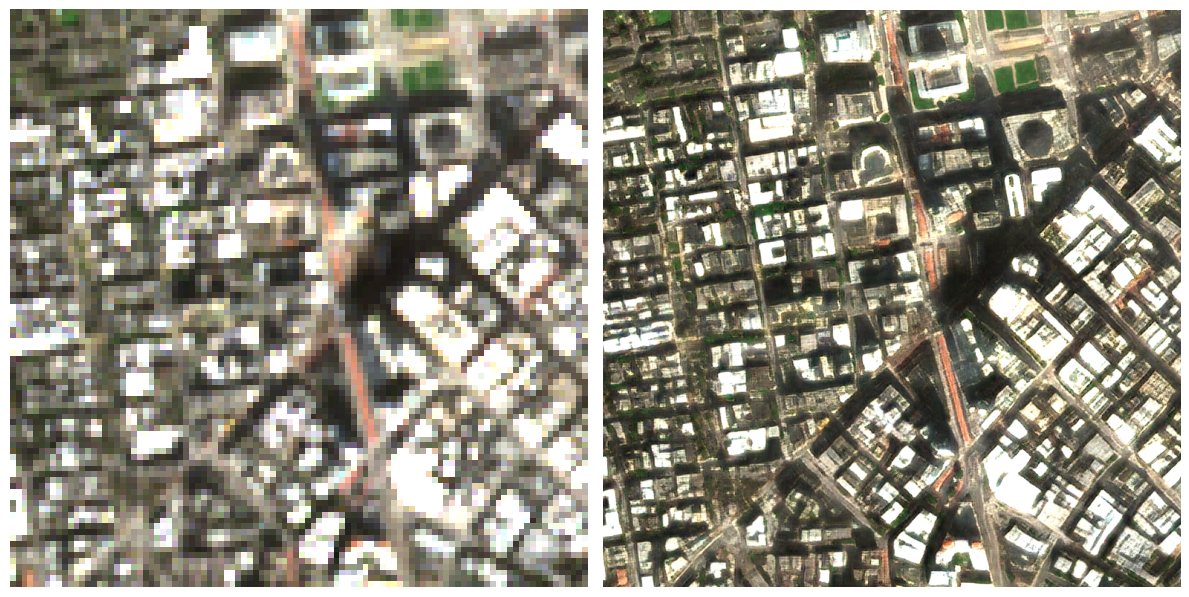



✅ S2DR3 complete! Generated 0 files:


Exception: ❌ Missing required outputs (MS or NDVI)

In [6]:
#@title 🎯 Step 3: Run S2DR3 Super-Resolution
import s2dr3.inferutils
import pathlib

print("🚀 Running S2DR3 inference...")
print(f"   📍 Target: ({lat:.4f}, {lon:.4f})")
print(f"   📅 Date: {date}")
print("   ⏱️  This will take 2-4 minutes...\n")

# Run S2DR3
lonlat = (lon, lat)
s2dr3.inferutils.test(lonlat, date)

# Find output files
output_dir = pathlib.Path("/content/output")
output_files = list(output_dir.glob("*.tif"))

print(f"\n✅ S2DR3 complete! Generated {len(output_files)} files:")
for f in output_files:
    size_mb = f.stat().st_size / 1024 / 1024
    print(f"   📄 {f.name} ({size_mb:.1f} MB)")

# Identify products
ms_file = next((f for f in output_files if "_MS.tif" in f.name), None)
ndvi_file = next((f for f in output_files if "_NDVI.tif" in f.name), None)
tci_file = next((f for f in output_files if "_TCI.tif" in f.name), None)
irp_file = next((f for f in output_files if "_IRP.tif" in f.name), None)

if not ms_file or not ndvi_file:
    raise Exception("❌ Missing required outputs (MS or NDVI)")

In [ ]:
#@title ✂️ Step 4: Clip to Farm Boundary (Optional)
# Install rasterio for clipping
!pip install -q rasterio

import rasterio
from rasterio.mask import mask
import json

print("✂️  Clipping images to farm boundary...\n")

def clip_to_farm(in_file, out_file, farm_geom):
    """Clip a GeoTIFF to farm boundary"""
    try:
        with rasterio.open(in_file) as src:
            # Extract geometry
            if farm_geom['type'] == 'Feature':
                geom = farm_geom['geometry']
            else:
                geom = farm_geom

            # Clip
            out_image, out_transform = mask(src, [geom], crop=True, all_touched=True)
            out_meta = src.meta.copy()

            # Update metadata
            out_meta.update({
                "driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform,
                "compress": "deflate"
            })

            # Write
            with rasterio.open(out_file, "w", **out_meta) as dest:
                dest.write(out_image)
                # Copy colormap if exists
                if src.colormap(1):
                    dest.write_colormap(1, src.colormap(1))

        return True
    except Exception as e:
        print(f"   ⚠️  Clipping failed: {e}")
        return False

# Create clipped directory
clipped_dir = pathlib.Path("/content/clipped")
clipped_dir.mkdir(exist_ok=True)

# Clip each file
clipped_files = {}

if ms_file:
    out_ms = clipped_dir / "ms_clipped.tif"
    if clip_to_farm(ms_file, out_ms, farm):
        clipped_files['ms'] = out_ms
        print(f"   ✅ MS clipped")

if ndvi_file:
    out_ndvi = clipped_dir / "ndvi_clipped.tif"
    if clip_to_farm(ndvi_file, out_ndvi, farm):
        clipped_files['ndvi'] = out_ndvi
        print(f"   ✅ NDVI clipped")

if tci_file:
    out_tci = clipped_dir / "tci_clipped.tif"
    if clip_to_farm(tci_file, out_tci, farm):
        clipped_files['tci'] = out_tci
        print(f"   ✅ TCI clipped")

print(f"\n✅ Clipped {len(clipped_files)} images to farm boundary")

In [ ]:
#@title 📤 Step 5: Upload to DHARTI
import requests
from tqdm.auto import tqdm

print("📤 Uploading enhanced images to DHARTI...\n")

upload_url = f"{api_base}/api/s2dr3/jobs/{job_id}/upload"
headers = {"Authorization": f"Bearer {upload_token}"}

# Prepare files for upload
files_to_upload = {}

if 'ms' in clipped_files:
    files_to_upload['ms'] = ('ms.tif', open(clipped_files['ms'], 'rb'), 'image/tiff')
    print(f"   📦 MS (multispectral) ready...")

if 'ndvi' in clipped_files:
    files_to_upload['ndvi'] = ('ndvi.tif', open(clipped_files['ndvi'], 'rb'), 'image/tiff')
    print(f"   📦 NDVI ready...")

if 'tci' in clipped_files:
    files_to_upload['tci'] = ('tci.tif', open(clipped_files['tci'], 'rb'), 'image/tiff')
    print(f"   📦 TCI (true color) ready...")

# Upload with progress bar
print(f"\n⏳ Uploading to {upload_url}...")

try:
    response = requests.post(upload_url, headers=headers, files=files_to_upload, timeout=300)

    # Close file handles
    for _, (_, f, _) in files_to_upload.items():
        f.close()

    if response.status_code == 200:
        result = response.json()
        print(f"\n✅ Upload successful!")
        print(f"   📊 Status: {result.get('status', 'unknown')}")

        saved_files = result.get('saved', {})
        if saved_files:
            print(f"   📁 Saved files:")
            for key, path in saved_files.items():
                print(f"      • {key}: {path}")

        print(f"\n🎉 Your enhanced 1m images are now available in DHARTI!")
        print(f"   🔄 Refresh your browser to see the super-resolved layer.")
        print(f"   🗺️  It will appear as: 'NDVI (S2DR3 1m, AI-enhanced)'")

    elif response.status_code == 403:
        print(f"\n❌ Upload denied: Invalid authentication token")
        print(f"   This job may have expired or the token is incorrect.")

    elif response.status_code == 404:
        print(f"\n❌ Job not found: {job_id}")
        print(f"   The job may have been deleted or doesn't exist.")

    else:
        print(f"\n❌ Upload failed: HTTP {response.status_code}")
        print(f"   Response: {response.text[:200]}")

except requests.exceptions.Timeout:
    print(f"\n⏱️  Upload timeout (>5 minutes)")
    print(f"   Your files may still be uploading. Check DHARTI status.")

except Exception as e:
    print(f"\n❌ Upload error: {e}")
    print(f"\n💡 You can manually download the files from /content/clipped/")
    print(f"   Then contact support to upload them manually.")

---

## ✅ Pipeline Complete!

The S2DR3 super-resolution has been successfully applied to your satellite imagery!

### What was processed:

- **Input**: Sentinel-2 10m resolution
- **Output**: AI-enhanced 1m resolution (10x improvement!)
- **Layers**: RGB (TCI), NDVI, Multi-spectral (10 bands)
- **Processing Time**: ~3-5 minutes on GPU

### What's Next?

1. **Return to DHARTI** web interface
2. The modal will **automatically refresh** and show your enhanced images
3. Use the **RGB/NDVI toggle** to switch between visualizations
4. **Download** high-resolution GeoTIFFs if needed

### Technical Details

- **Model**: S2DR3 (Sentinel-2 Deep Residual Refine & Restore)
- **Resolution**: 10x super-resolution (10m → 1m)
- **Architecture**: ResNet-based deep learning model
- **Output Format**: GeoTIFF with proper georeferencing
- **CRS**: EPSG:4326 (WGS84)

### Troubleshooting

If you don't see the images in DHARTI:

1. Check that the upload completed successfully (green ✅ above)
2. Refresh the DHARTI page
3. Check browser console for errors
4. Verify the job_id matches what you clicked in DHARTI

---

**🎉 Powered by DHARTI + S2DR3**

*This automated pipeline brings professional-grade AI super-resolution to agricultural satellite imagery!*
